In [165]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy.stats import norm, skew
from scipy import stats
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Conjuntos de dados

o conjunto de dados utilizado é referente a dados minerados de anúncios online de venda imóveis na cidade pernambucana de Recife. O conjunto foi disponibilizado no desafio da disciplina DEL/UFRJ - EEL891. 

In [166]:
df_train = pd.read_csv("data/train.csv",sep=',')
df_test = pd.read_csv("data/test.csv",sep=',')

# salvamos os ids do conjunto de testes para adicionar posteiromente em nosso dataset de submissão para o Kaggle
# além disso adicionamos uma coluna temporária de preço no conjunto de testes, de modo a o deixar com a mesma
# dimensão do conjunto de treino, facilitando assim transformações nesses dados

test_ids = df_test['Id']
df_test['preco'] = None

train_size = len(df)
df_train.head(3)

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0


Além do conjunto de treino fornecido no desafio, será utilizado também um conjunto de informações complemetares, disponibilizadas publicamente pelo governo de Pernambuco no site do [Banco de dados do Estado](http://www.bde.pe.gov.br/visualizacao/Visualizacao_formato2.aspx?CodInformacao=1162&Cod=3). Essas informações são referentes a distribuição de renda média dentro de cada um dos bairros da cidade de Recife e foram coletados no ano de 2010.

In [167]:
neighborhood_income = pd.read_csv("data/renda_bairros.csv",sep=',')

# dados faltantes significam que não foram encontaradas pessoas em uma faixa de renda em certo bairro
neighborhood_income.iloc[:,2:] = neighborhood_income.iloc[:,1:].fillna(0)

# convertemos o número absoluto de pessoas em cada faixa de renda para uma porcentagem relativa ao tamanho do bairro
# dessa forma evitamos distorções causadas por disparidades no tamanho da população de cada bairro
neighborhood_income.iloc[:, 2:] = neighborhood_income.iloc[:, 2:].divide(neighborhood_income.iloc[:,1], axis = 'rows')

neighborhood_income = neighborhood_income.drop(columns=['Total ¹'])
neighborhood_income.head(3)

,bairro,Até 1/2 salário mínimo,Mais de 1/2 a 1 salário mínimo,Mais de 1 a 2 salários mínimos,Mais de 2 a 5 salários mínimos,Mais de 5 a 10 salários mínimos,Mais de 10 a 20 salários mínimos,Mais de 20 salários mínimos,Sem rendimento
0,Aflitos,0.002581,0.012390,0.026846,0.094476,0.223542,0.308725,0.273619,0.057821
1,Afogados,0.036308,0.194274,0.253974,0.301842,0.114884,0.033779,0.006954,0.057984
2,Agua Fria,0.055393,0.219538,0.296974,0.285993,0.070360,0.013584,0.002603,0.055556


## Pré processamento dos dados

### Remoção de outliers

O conjunto de dados possui 3 variáveis contínuas com grande variância, são elas: preço do imóvel, área útil e área extra. Através da plotagem do boxplot é possível verificar que existem outliers em todas essas variáveis, o que pode atraplhar de maneira significativa o desempenho de modelos de regressão.

Sendo assim, a primeira etapa de pré processamente dos dados será a remoção das linhas em que umas dessas três variáveis é outlier.

4531 linhas no dataset


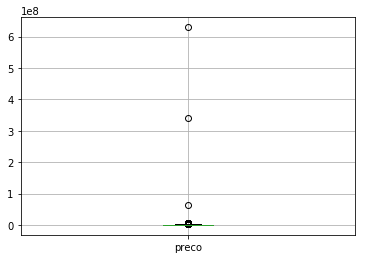

In [168]:
df_train.boxplot(column = ['preco'])
original_size = len(df_train)
print("{} linhas no dataset".format(train_size))

4531 linhas no dataset
Diminuição de 3.25% no tamanho do conjunto de treino


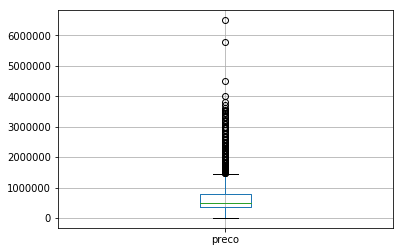

In [169]:
columns = ['preco','area_extra','area_util']

for column in columns:
    df_train = df_train[np.abs(df_train[column] - df_train[column].mean()) <= (2 * df_train[column].std())]

df_train.boxplot(column = ['preco'])

print("{} linhas no dataset".format(len(df_train['preco'])))
redu = round(((original_size - len(df_train))/original_size)* 100,2)
print("Diminuição de {}% no tamanho do conjunto de treino".format(redu))

Unificaremos agora os dados de treino e testes para aplicar as transformações necessárias e tornaremos a separar esses dados antes de realizar o treinamento dos modelos.

In [170]:
train_size = len(df_train)
df = pd.concat((df_train, df_test))

### Agregação de dados de distribuição de renda

Como forma de enriquecer o conjunto de treino, adicionamos 8 novas colunas referentes a distribuição de renda nos bairros. Alguns dos bairros presentes no conjunto de treino não são de fato bairros da cidade de Recife, mas sim pontos de referência ou subregiões. Nesses casos preencheremos essas linhas com uma distribuição uniforme de renda.

In [171]:
# adicionamos novas colunas vazias no dataset
income_columns = ['meio_salario','meio_1_salario','1_2_salarios','2_5_salarios','5_10_salarios','10_20_salarios','20_salarios','sem_salario']
df = pd.concat([df, df.reindex(columns = income_columns)], axis = 1)

# tratamos dados que não são bairros de fato
all_neighborhood = list(df.bairro.unique())

skip_neighborhood = ['Beira Rio', 'Centro']
neighborhood = list(set(all_neighborhood).symmetric_difference(skip_neighborhood))

df.loc[df.bairro == 'Beira Rio', income_columns] = 1/len(income_columns)
df.loc[df.bairro == 'Centro', income_columns] = 1/len(income_columns)

# agergamos ao dataset os dados do conjunto de dados de renda média por bairro
for neighborhood_name in neighborhood:
        df.loc[df.bairro == neighborhood_name, income_columns] = neighborhood_income[neighborhood_income['bairro'] == neighborhood_name].iloc[:,1:].values

df.head(3)

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,vista_mar,preco,meio_salario,meio_1_salario,1_2_salarios,2_5_salarios,5_10_salarios,10_20_salarios,20_salarios,sem_salario
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1e+06,0.041486,0.165743,0.224197,0.281916,0.154787,0.073218,0.017770,0.040884
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,680000,0.012156,0.101979,0.141028,0.269471,0.188038,0.153292,0.101764,0.032272
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,450000,0.003992,0.036427,0.066617,0.208084,0.285180,0.239521,0.147455,0.012725


### Binarização de variáveis

Aplicaremos a técnica de **one hot encoding** para binarizar o bairro de cada imóvel. Logo, cada um desses bairros se tornará uma coluna binária que em cada linha terá valor 1 para um dos bairros e zero para todos os demais.

Além disso, serão removidas as colunas *Id, tipo do vendedor e diferencial*. A coluna *¨Id¨* não agrega nenhuma informação aos dados, sendo apenas um identificador. As informações da coluna *¨diferencial¨* já estão contidas em outras colunas binárias. Por fim, a coluna *´tipo´* agrega poucas informação uma vez que mais de 95% dos dados estão preenchidos com o valor *¨imobiliária¨*.


In [112]:
hot_columns = pd.get_dummies(df['bairro'], prefix= 'bairro')
df = pd.concat([df, hot_columns], axis = 1)
df = df.drop(columns=['bairro'])

### Normalização dos dados

Por fim, normalizaremos as seguintes colunas: *¨area_util¨*, *´area_extra´* ,*´quartos´*, *´suites´* e *´vagas´*.

Isso é feito ara que elas não tenham uma escala destoante dos demais dados. As demais colunas não precisam ser normalizas, visto que ou são binárias ou representam uma probabilidade *(valores entre 0 e 1)*.

Utilizaremos a normalização do tipo **Min-Max**.

In [172]:
from sklearn.preprocessing import minmax_scale


df[['area_util','area_extra','quartos','suites','vagas']] = minmax_scale(df[['area_util','area_extra','quartos','suites','vagas']])
df = df.drop(columns=['Id','diferenciais','tipo_vendedor','tipo'])
df.head(3)

,bairro,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,...,vista_mar,preco,meio_salario,meio_1_salario,1_2_salarios,2_5_salarios,5_10_salarios,10_20_salarios,20_salarios,sem_salario
0,Imbiribeira,0.222222,0.500000,0.166667,0.076131,0.013847,0,0,1,0,...,0,1e+06,0.041486,0.165743,0.224197,0.281916,0.154787,0.073218,0.017770,0.040884
1,Casa Amarela,0.333333,0.666667,0.066667,0.051857,0.000000,1,0,1,0,...,0,680000,0.012156,0.101979,0.141028,0.269471,0.188038,0.153292,0.101764,0.032272
2,Encruzilhada,0.222222,0.166667,0.000000,0.013608,0.000000,0,0,0,0,...,0,450000,0.003992,0.036427,0.066617,0.208084,0.285180,0.239521,0.147455,0.012725


Agora que realizamos todas as transformações comuns ao conjunto de treino e de teste, tornaremos a separá-los em duas variáveis distintas.

In [173]:
df_test = df.iloc[train_size:,:]
df_test = df_test.drop(columns=['preco'])
df = df.iloc[:train_size,:]
df = df.convert_objects(convert_numeric=True)

## Transformação da variável algo para distribuição normal

Os preços de imóveis tendem a ter uma distribuição de cauda pesada, o que não é o mais adequado para a aplicação de modelos de regressão. Aplicaremos a transformação **log1p** do scikit-learn para aproximar essa distribuição de uma normal e assim melhorar eficiência dos modelos de regressão.

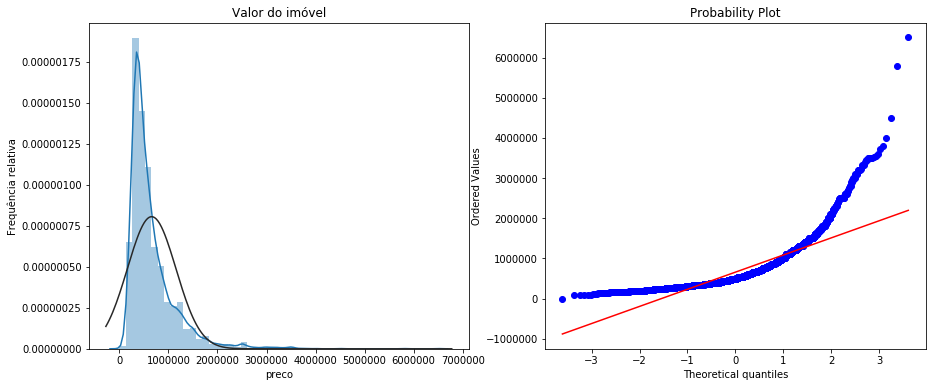

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(df['preco'])

axes[0].set_ylabel('Frequência relativa')
axes[0].set_title('Valor do imóvel')


stats.probplot(df['preco'], plot = axes[1])
plt.show()

Verificamos então como ficam os dados após a transformação:

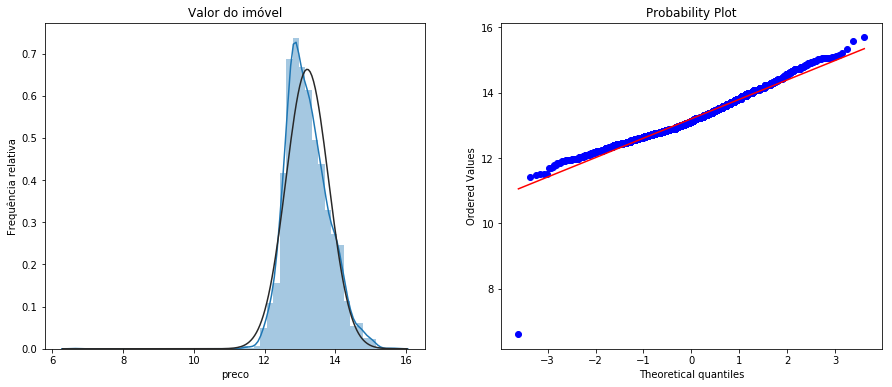

In [116]:
# aplicação da transformação
df['preco'] = np.log1p(df['preco'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(df['preco'])

axes[0].set_ylabel('Frequência relativa')
axes[0].set_title('Valor do imóvel')


stats.probplot(df['preco'], plot = axes[1])
plt.show()

Por fim, separamos o conjunto de treino em duas variáveis, uma referêntes aos parâmetros X para treinar ao modelo e outra referente ao ¨gabarito¨ Y.

In [117]:
target = df['preco']
parameters = df.copy().drop(columns=['preco'])

## Modelos

Testaremos agora o desempenho de diferentes modelos de regressão na tarefa de predição do preço de imóveis. Foi dada prioridade na utilização dos modelos estudados na matéria *EEL891*, como forma de explorar os conceitos teóricos abordados em aula a sermos capazes de nos aprofundar nos ajustes finos e parametrizações disponíveis em cada um desses modelos.

Os modelos de predição testados foram:

- Regressão polinomial
- Regressão Ridge
- Regressão Lasso
- Elastic Net
- Ridge bayessiano
- Florestas aleatórias
- LGBM

### Validação dos modelos

Para a validação dos modelos treinados será utilizada a técnica de **validação cruzada**. A cada modelo serão feitas 5 execuções com validação cruzada e calculada a média dos resultados. A métrica de erro utilizada, como sugerido no desafio, será o **RMSPE**.

In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

# número de folds na validação cruzadas
cv_number = 5

# função RMSPE a ser utilizada como métrica de erro
def rmspe(y_pred, y):
    rmspe = np.sqrt(np.mean( (1/ y**2) * (y_pred - y)**2 ))
    return rmspe

rmspe_score = make_scorer(rmspe, greater_is_better=False)

## dataset para armazenar o resultado dos modelos
results = pd.DataFrame([], columns = ['mean', 'std'])

In [120]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline

polynomial = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear',linear_model.LinearRegression(copy_X =  True))]) 

scores = cross_val_score(polynomial,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = 2)

results.loc['Polynomial'] = [-scores.mean(), scores.std()]

### Ridge Regression

Melhor resultado obtido com alpha = 0.015014028056112225, resultado obtido: 0.020369802075933002


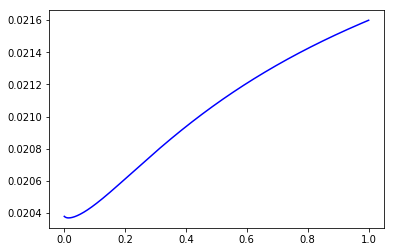

In [126]:
from sklearn.preprocessing import PolynomialFeatures

# iteramos em um intervalo de alpha que pensamos ser o mais proveitoso, de forma a achar o alpha ótimo ou ao menos um
# mínimo local

ridge_alpha_tunning = []

domain = list(np.linspace(0.001,1,500))
for alpha_value in domain:    
    ridge = linear_model.Ridge(alpha = alpha_value, max_iter = 1000, random_state = 161095)
    scores = cross_val_score(ridge,
                             parameters,
                             target,
                             scoring = rmspe_score,
                             cv = cv_number)
    ridge_alpha_tunning.append(-np.mean(scores))

# removemos alhpas muito grandes (em alguns casos descontinuidades) para facilitar a plotagem dos resultados
while max(ridge_alpha_tunning) > 1:
        index  = ridge_alpha_tunning.index(max(ridge_alpha_tunning))
        del domain[index]
        del ridge_alpha_tunning[index]
        
best_alpha = domain[ridge_alpha_tunning.index(min(ridge_alpha_tunning))]
ridge = linear_model.Ridge(alpha = best_alpha, max_iter = 1000, random_state = 161095)
scores = cross_val_score(ridge,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

# salvamos o resultado do melhor alpha em nosso dataframe de resultados
results.loc['Ridge'] = [-scores.mean(), scores.std()]

print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(best_alpha, min(ridge_alpha_tunning)))

plt.plot(domain, ridge_alpha_tunning, color='b')

### Lasso regression

Melhor resultado obtido com alpha = 7.006012024048097e-05, resultado obtido: 0.02030279461122746


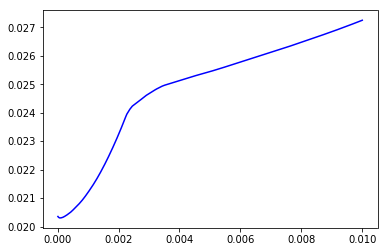

In [133]:
lasso_alpha_tunning = []
domain = list(np.linspace(0.00001,0.01,500))
for alpha_value in domain:    
    lasso = linear_model.Lasso(alpha = alpha_value,random_state = 161095)
    scores = cross_val_score(lasso,
                             parameters,
                             target,
                             scoring = rmspe_score,
                             cv = cv_number)
    lasso_alpha_tunning.append(-np.mean(scores))


while max(lasso_alpha_tunning) > 1:
        index  = lasso_alpha_tunning.index(max(lasso_alpha_tunning))
        del domain[index]
        del lasso_alpha_tunning[index]
        
best_alpha = domain[lasso_alpha_tunning.index(min(lasso_alpha_tunning))]
lasso = linear_model.Lasso(alpha = alpha_value,random_state = 161095, max_iter = 3000)
scores = cross_val_score(lasso,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['Lasoo'] = [-scores.mean(), scores.std()]

print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(domain[lasso_alpha_tunning.index(min(lasso_alpha_tunning))],min(lasso_alpha_tunning)))
plt.plot(domain, lasso_alpha_tunning, color='b')

### Elastic Net

Melhor resultado obtido com alpha = 1e-05, resultado obtido: 0.02035855871834857


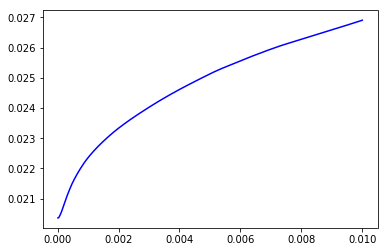

In [134]:
from sklearn.linear_model import ElasticNet

elastic_alpha_tunning = []
domain = list(np.linspace(0.000001,0.01,500))
for alpha_value in domain:    
    elastic_net = ElasticNet(alpha = alpha_value, l1_ratio= 0.6, copy_X = True,random_state = 161095)
    scores = cross_val_score(elastic_net,
                             parameters,
                             target,
                             scoring = rmspe_score,
                             cv = cv_number)
    elastic_alpha_tunning.append(-np.mean(scores))


while max(elastic_alpha_tunning) > 1:
        index  = elastic_alpha_tunning.index(max(elastic_alpha_tunning))
        del domain[index]
        del elastic_alpha_tunning[index]
        
best_alpha = domain[elastic_alpha_tunning.index(min(elastic_alpha_tunning))]
elastic_net = ElasticNet(alpha = alpha_value, l1_ratio= 0.6, copy_X = True,random_state = 161095)
scores = cross_val_score(elastic_net,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['ElasticNet'] = [-scores.mean(), scores.std()]
        
print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(domain[elastic_alpha_tunning.index(min(elastic_alpha_tunning))],min(elastic_alpha_tunning)))
plt.plot(domain, elastic_alpha_tunning, color='b')

### Bayesian Ridge

In [121]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()

scores = cross_val_score(bayesian_ridge,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['BayesianRidge'] = [-scores.mean(), scores.std()]

### Random Forest

In [122]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100)

scores = cross_val_score(random_forest,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['RandomForest'] = [-scores.mean(), scores.std()]

### LGBoost

In [123]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate = 0.1, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 3, min_sum_hessian_in_leaf = 5)

scores = cross_val_score(lgbm,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['LGBM'] = [-scores.mean(), scores.std()]

### KNN

In [124]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

scores = cross_val_score(knn,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['KNeighbors'] = [-scores.mean(), scores.std()]

In [135]:
results

,mean,std
Polynomial,0.276174,0.015512
BayesianRidge,0.020379,0.002045
RandomForest,0.018900,0.002284
LGBM,0.018779,0.002050
KNeighbors,0.026551,0.001757
Ridge,0.020370,0.002050
Lasoo,0.027245,0.001880
ElasticNet,0.026906,0.001828


## Conclusões e submissões



In [153]:
result = pd.DataFrame()
result['Id'] = test_ids

In [157]:
lgbm = random_forest = RandomForestRegressor(n_estimators = 100)

lgbm.fit(parameters, target)
lgbm_predictions = lgbm.predict(df_test)

transform_predict = np.expm1(lgbm_predictions)
result['preco'] = transform_predict

In [158]:
result.to_csv('submission.csv', index=False)